# A demonstration for Controversial $F_1$ Metrics

This demonstration was created for evaluation metrics in the field of forged image localization to evaluate the reasonableness of various rating methods. 

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import cv2
import prettytable

In order to get a calculation for a more realistic case, we took the [ground truth](https://github.com/CHELSEA234/HiFi_IFDL/blob/main/asset/sample_3_GT.png) and the [prediction](https://github.com/CHELSEA234/HiFi_IFDL/blob/main/asset/sample_3_pred.png) shown in the HiFi-IFDL repository. We downloaded them to the asset directory in the current directory and renamed them to GT.png and pred.png.

First we read the ground truth $G$ and prediction $P$ from disk.

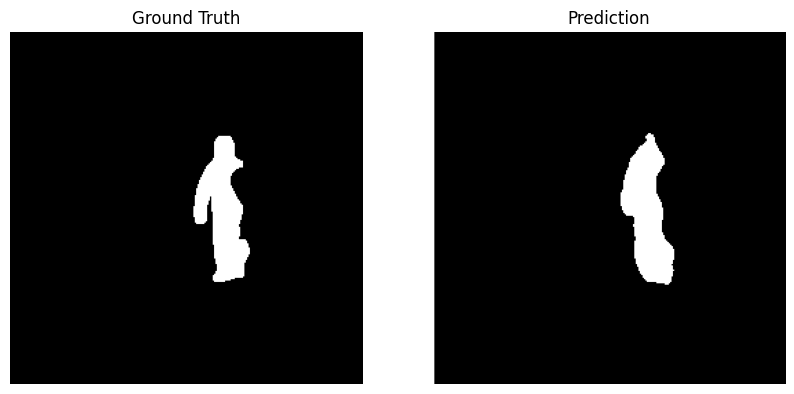

In [4]:

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = (img / 255).astype(np.int32)
    return img

def show_2_images(x:np.ndarray, x_lable:str, y:np.ndarray, y_lable:str):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(x, cmap='gray')
    ax[0].set_title(x_lable)
    ax[0].axis('off')

    ax[1].imshow(y, cmap='gray')
    ax[1].set_title(y_lable)
    ax[1].axis('off')

    plt.show()


G = load_image("./asset/GT.png")
P = load_image("./asset/pred.png")

show_2_images(G, "Ground Truth", P, "Prediction")

## 1. Common predictions 

It is easy to see from the naked eye that the prediction is still relatively accurate, in this case we use the binary and macro methods to calculate f1, to explore the effect of different methods on the score.

In [3]:
# for displaying metrics
table = prettytable.PrettyTable(["ID","Method","F1 score"])
table.align["Method"] = "l"

def format_f1(f1):
    return f"{f1:.2f}"

def caculate_f1_binary_macro(target, predict):
    f1_binary_acc =  metrics.f1_score(target.flatten(), predict.flatten(),average='binary')
    f1_macro_acc =  metrics.f1_score(target.flatten(), predict.flatten(),average='macro')
    return f1_binary_acc, f1_macro_acc

f1_binary_common, f1_macro_common = caculate_f1_binary_macro(G, P)
table.add_row(["1","binary_common",format_f1(f1_binary_common)])
table.add_row(["2","macro_common",format_f1(f1_macro_common)])
table

ID,Method,F1 score
1,binary_common,0.84
2,macro_common,0.92


The results show that using macro is 7 points higher than using binary. 

We can derive the analysis from the following equation

$$
F1_{macro} - F1_{binary} = \frac{1}{2+\frac{FP+FN}{TN}} - \frac{1}{2+\frac{FP+FN}{TP}}
$$

Since $FP+FN>0$, there is $F1_{macro} - F1_{binary} > 0$ when $TN > TP$, and this is a very common situation in IMDL because it is usually easier to predict correctly more backgrounds compared to predicting correctly forged region for models

So when use macro, the $F_1$ score usually higher than binary.

## 2. Black predictions

In the course of our research we found that some models produce all-black images when predicting some images, for this case we use macro and binary methods to calculate them separately.

First we manually create an all-black mask to simulate the output of the model

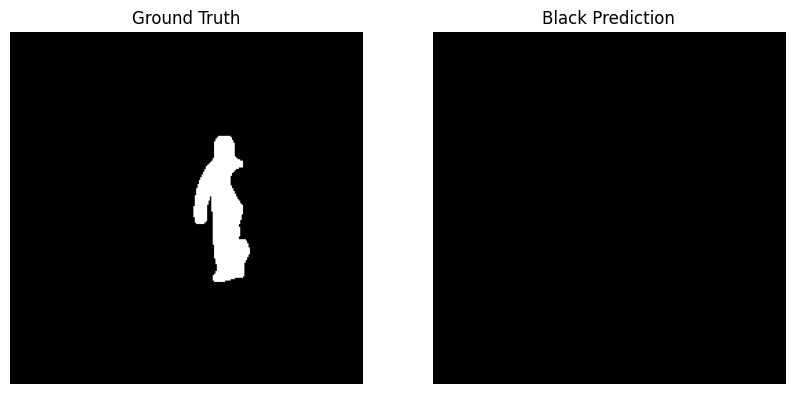

In [4]:
black_pred = np.zeros((G.shape[0], G.shape[1]))

show_2_images(G, "Ground Truth", black_pred, "Black Prediction")

Then we perform the calculation of f1 score under binary and macro respectively.

In [5]:
f1_binary_black = metrics.f1_score(G.flatten(), black_pred.flatten())
f1_macro_black = metrics.f1_score(G.flatten(), black_pred.flatten(),average='macro')

table.add_row(["3","binary_black",format_f1(f1_binary_black)])
table.add_row(["4","macro_black",format_f1(f1_macro_black)])
table

ID,Method,F1 score
1,binary_common,0.84
2,macro_common,0.92
3,binary_black,0.00
4,macro_black,0.49


Theoretically when the model's prediction is all black, it should be given a very low score due to the fact that it is far from the GROUND TRUTH and the model has made very little contribution. From the results, we can see that the macro case has a score of 0.49, which is very unreasonable compared to the binary's 0.

We can derive the analysis from the following equation

$$
\begin{align*}

F1_{macro} & = \frac{TP}{2TP + FP + FN} + \frac{TN}{2TN + FP + FN} \\

F1_{binary} & = \frac{2TP}{2TN + FP + FN}

\end{align*}
$$

In the case of total blackness, $TP = 0$,$FP = 0$, $TN \neq 0$, $FN\neq 0$. Also in this case $TN+FN$ equal to the area of the image $I$.

$$
\begin{align*}

F1_{macro} & =  \frac{TN}{2TN + FN} = \frac{1}{1+\frac{I}{TN}} = \frac{1}{ 1 + \frac{1}{\alpha}} \\

\alpha &= \frac{TN}{I}  \\

F1_{binary} & = 0

\end{align*}
$$


$\alpha$ is the proportion of the background area in the ground truth image. Next we draw the curve of $F_1$ score with $\alpha$.

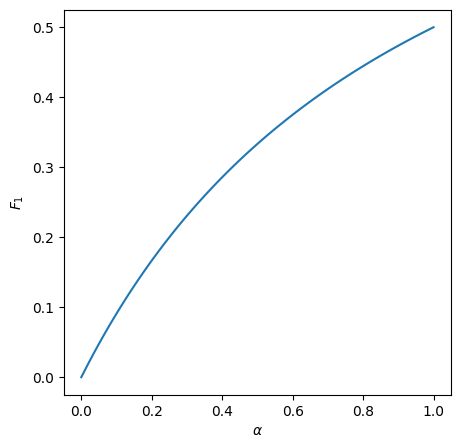

In [6]:
def f1_score_founction_for_black_out(alpha):
    sigma = 0.0001
    return 1/(1+1/(alpha+sigma))

x = np.linspace(0, 1, 100)
y = f1_score_founction_for_black_out(x)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, y)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$F_1$')
plt.show()

It is easy to see from the curves that the f1 score computed using the MACRO approach rises as the background becomes a higher and higher fraction of G. The f1 score computed using the MACRO approach rises as well. And usually the proportion of background in G is relatively high. In this case, the f1 score will be inflated.

Next we count the percentage of the background in G then enter the formula to calculate the validation.

In [7]:
white_count = np.sum(G == 1)
black_count = np.sum(G == 0)
total_count = white_count + black_count
print(f"total_count: {total_count}")
alpha = black_count / (white_count + black_count)
print(f"alpha: {alpha:.2f}")
print(f"score: {f1_score_founction_for_black_out(alpha):.2f}")

total_count: 65536
alpha: 0.96
score: 0.49


The percentage of background in G is 0.96, and the calculated f1 score of 0.49 is consistent with the previously obtained results, and the validation is successful.

In short, the macro doesn't respond well to model levels when predicting full black, and can lead to very much f1 fudge

## 3. No overlap

This situation also occurs in IMDL, where the model predicts has none same region with the ground truth, and we can use the same method to calculate the f1 score. First, we manually create a mask with no overlap with the ground truth to simulate the output of the model.

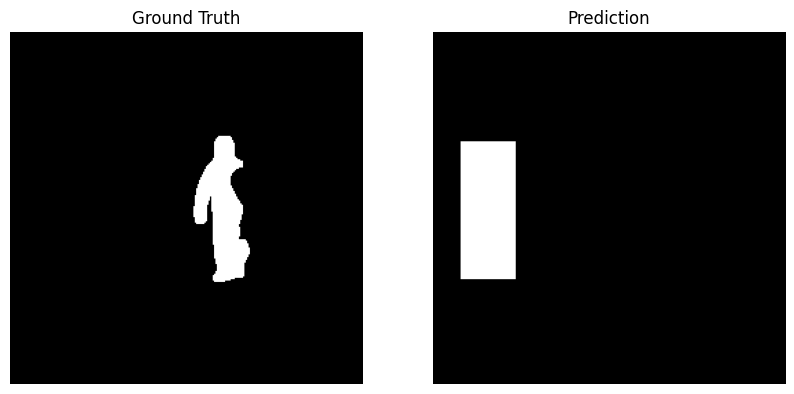

In [8]:
P = np.zeros_like(G)
# draw a rectangle
P[80:180, 20:60] = 1
show_2_images(G, "Ground Truth", P, "Prediction")



Then we perform the calculation of f1 score under binary and macro respectively.

In [9]:
f1_binary_no_overlap, f1_macro_no_overlap = caculate_f1_binary_macro(G, P)
table.add_row(["5","binary_no_overlap",format_f1(f1_binary_no_overlap)]) 
table.add_row(["6","macro_no_overlap",format_f1(f1_macro_no_overlap)])
table

ID,Method,F1 score
1,binary_common,0.84
2,macro_common,0.92
3,binary_black,0.00
4,macro_black,0.49
5,binary_no_overlap,0.00
6,macro_no_overlap,0.47


When the prediction and ground truth do not overlap at all, the 0 obtained from the binary calculation is more reasonable than the 0.47 obtained from macro

## 5. Conclusion

1. Using macro can lead to inflated scores for models.
2. Macro does not truly reflect the true performance of the model, and is best reflected in the all-black prediction and the no-overlap case. The higher scores it generates relative to binary's 0 are very unreasonable.

It is best to use the binary method in IMDL to calculate the f1 score.